<a href="https://colab.research.google.com/github/ingalegb/robot_trading/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Robot Trading - CHALLENGE N°1

## 1- Ambiente de Trabajo

##1.1Definición de Variables y Bibliotecas

In [ ]:
!python -V


Python 3.10.11


In [ ]:
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import yfinance as yf


In [ ]:
!pip show Pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, google-colab, gspread-dataframe, holoviews, mizani, mlxtend, pandas-datareader, pandas-gbq, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance


In [ ]:
!pip show Numpy

Name: numpy
Version: 1.22.4
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair, arviz, astropy, autograd, blis, bokeh, chex, cmdstanpy, contourpy, cufflinks, cvxpy, datascience, db-dtypes, dopamine-rl, ecos, flax, folium, gensim, gym, h5py, holoviews, hyperopt, imageio, imbalanced-learn, imgaug, jax, jaxlib, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, opencv-contrib-python, opencv-python, opencv-python-headless, opt-einsum, optax, orbax-checkpoint, osqp, pandas, pandas-gbq, patsy, plotnine, prophet, pyarrow, pycocotools, pyerfa, pymc, pytensor, python-louvain, PyWavelets, qdldl, qudida, scikit-image, scikit-learn, scipy, scs, seaborn, shapely, sklearn-pandas, soxr, spacy, statsmodels, tabl

In [ ]:
!pip show Matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.10/dist-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, datascience, fastai, imgaug, matplotlib-venn, missingno, mizani, mlxtend, music21, plotnine, prophet, pycocotools, seaborn, wordcloud, yellowbrick


In [ ]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##2 Obtención de datos


###2.1 Obtención de histórico de precios Bitcoin


In [68]:
#Definir la página para extraer la información
from bs4 import BeautifulSoup
import requests
headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
url='https://coinmarketcap.com/'
respuesta = requests.get(url, headers=headers)

In [ ]:
  s=BeautifulSoup(respuesta.content, features='lxml')

In [ ]:
#Histórico de precios del Bitcoin en dólares BTC-USD, de los últimos 7  días, en intervalos de 5 minutos
def importar_base_bitcoin():
    global df_bitcoin
    data = yf.download( tickers  =  "BTC-USD" ,   # lista de tickers 
                              period  =  "7d" ,          # time period 
                              interval  =  "5m")        # trading interval 
    df_bitcoin = pd.DataFrame(data)
    return df_bitcoin

###2.2 Tendencias del Bitcoin

In [ ]:
#Tendencias del Bitcoin
def extraer_tendencias():
  global precio_actual, tendencia, variacion

  # Extraer el precio actual del Bitcoin BTC en dólares USD
  precio_actual=s.find('div',{'class':'sc-cadad039-0 clgqXO'}).get_text().replace('$','').replace(',','')
  precio_actual=float(precio_actual)

  #Obtener la variación de la última hora
  variacion=s.find('span',{'class':'sc-97d6d2ca-0 cYiHal'}).get_text().replace('%','')
  variacion=float(variacion)

  #Obtener la tendencia
  tendencia_variacion= s.find('span',class_=['icon-Caret-up','icon-Caret-down'])
  if 'icon-Caret-up' in tendencia_variacion:
    tendencia = 'alta'
  else:
    tendencia = 'baja'

    return[precio_actual,tendencia, variacion]

In [ ]:
importar_base_bitcoin()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-16 00:00:00+00:00,27171.513672,27180.341797,27171.226562,27171.226562,27171.226562,0
2023-05-16 00:05:00+00:00,27170.492188,27202.392578,27170.492188,27202.392578,27202.392578,11909120
2023-05-16 00:10:00+00:00,27221.753906,27222.830078,27208.285156,27222.830078,27222.830078,25136128
2023-05-16 00:15:00+00:00,27221.365234,27270.158203,27221.365234,27270.158203,27270.158203,0
2023-05-16 00:20:00+00:00,27264.189453,27287.683594,27264.189453,27287.683594,27287.683594,0
...,...,...,...,...,...,...
2023-05-22 03:00:00+00:00,26648.695312,26652.457031,26648.472656,26651.652344,26651.652344,59392
2023-05-22 03:05:00+00:00,26651.152344,26662.076172,26649.759766,26655.794922,26655.794922,9261056
2023-05-22 03:10:00+00:00,26650.056641,26650.515625,26646.628906,26646.628906,26646.628906,14504960


In [ ]:
extraer_tendencias()

[26636.53, 'baja', 0.13]

##3. Limpieza datos


In [ ]:
#Realizamos una copia del dataframe para mantener la base original
df_bitcoin_limpio = pd.DataFrame.copy(df_bitcoin)

In [ ]:
df_bitcoin_limpio

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-16 00:00:00+00:00,27171.513672,27180.341797,27171.226562,27171.226562,27171.226562,0
2023-05-16 00:05:00+00:00,27170.492188,27202.392578,27170.492188,27202.392578,27202.392578,11909120
2023-05-16 00:10:00+00:00,27221.753906,27222.830078,27208.285156,27222.830078,27222.830078,25136128
2023-05-16 00:15:00+00:00,27221.365234,27270.158203,27221.365234,27270.158203,27270.158203,0
2023-05-16 00:20:00+00:00,27264.189453,27287.683594,27264.189453,27287.683594,27287.683594,0
...,...,...,...,...,...,...
2023-05-22 03:00:00+00:00,26648.695312,26652.457031,26648.472656,26651.652344,26651.652344,59392
2023-05-22 03:05:00+00:00,26651.152344,26662.076172,26649.759766,26655.794922,26655.794922,9261056
2023-05-22 03:10:00+00:00,26650.056641,26650.515625,26646.628906,26646.628906,26646.628906,14504960


In [ ]:
#Funcion limpiar DataFrame
def limpieza_de_datos():  
  global df_bitcoin_limpio, media_bitcoin
  #Para la limpieza utilizaremos los atributos Datetime, Close y Volume.

  #Eliminamos índices nulos
  df_bitcoin_limpio.index.drop_duplicates()

  #Buscamos valores nulos en la columna Close y se eliminan
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)

  #Eliminamos los valores menores a 0 de la columna Volume
  df_bitcoin_volume = df_bitcoin_limpio['Volume']>0
  df_bitcoin_limpio=df_bitcoin_limpio[df_bitcoin_volume]

  #Identificamos y eliminamos los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot.
  %matplotlib inline
  import pandas as pd
  import matplotlib.pyplot as plt
  plt.rc('figure', figsize= (15,7))
  df_bitcoin_limpio['Close'].head(10) 

  Q1 = df_bitcoin_limpio.quantile(.25)
  Q3 = df_bitcoin_limpio.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5*IIQ
  limite_superior = Q3 + 1.5*IIQ
  seleccion = ((df_bitcoin_limpio>= limite_inferior)&(df_bitcoin_limpio <= limite_superior))
  df_bitcoin_limpio_=df_bitcoin_limpio[seleccion]

  #Se calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin
  media_bitcoin=df_bitcoin_limpio['Close'].mean()

  return media_bitcoin

Text(0.5, 1.0, 'Tendencia Bitcoin con Tratamiento de datos')

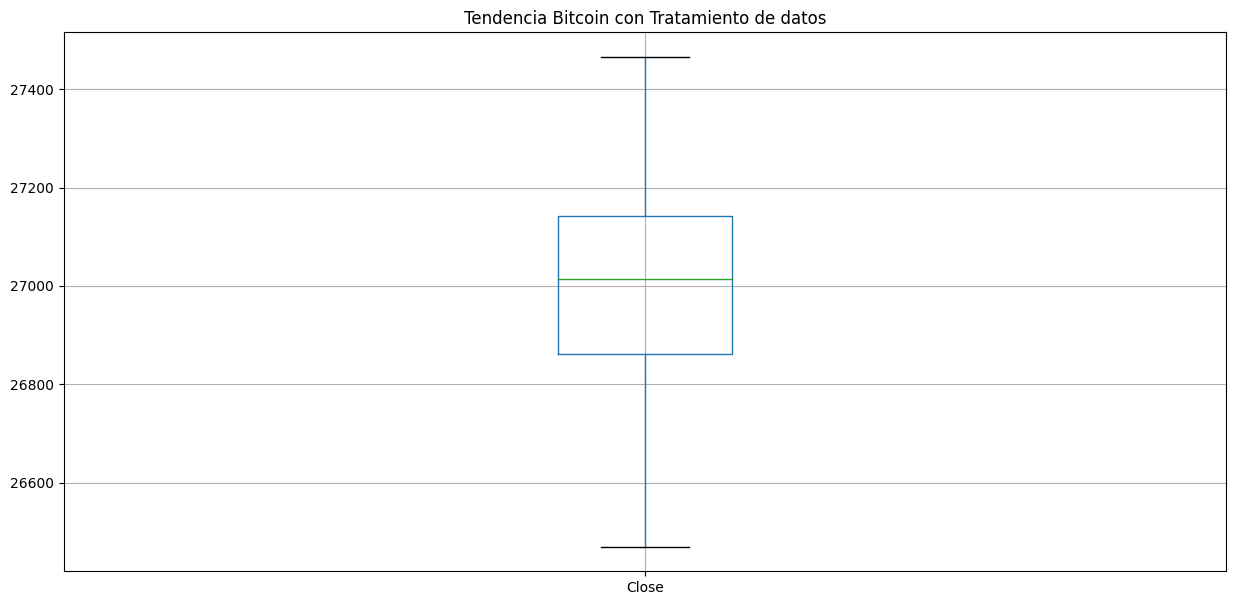

In [ ]:
limpieza_de_datos()
df_bitcoin_limpio.boxplot(['Close'])
plt.title('Tendencia Bitcoin con Tratamiento de datos')

## 4. Toma de decisiones

In [ ]:
def tomar_decisiones():
    global precio_actual, media_bitcoin, tendencia, algoritmo_de_decision
    if ((precio_actual >= media_bitcoin)&(tendencia == 'baja')):
      algoritmo_de_decision='Vender'
      print('Se sugiere Vender')
    elif ((precio_actual < media_bitcoin)&(tendencia == 'alta')):  
      algoritmo_de_decision='Comprar'
      print('Se sugiere Comprar')
    else:
      algoritmo_de_decision='Esperar'
      print('Se sugiere Esperar')
    return tomar_decisiones

In [ ]:
tomar_decisiones()

Se sugiere Esperar


<function __main__.tomar_decisiones()>

##Visualizaciones

In [ ]:
def visualizaciones():
  import numpy as np
  %matplotlib inline
  import matplotlib.pyplot as plt
  
  global media_bitcoin

  #Agregamos una nueva columna (Promedio) al dataframe original df_bitcoin y almacena el valor de nuestra variable media_bitcoin.
  df_bitcoin['Promedio'] = media_bitcoin

 #Configura el tamaño del gráfico en una proporción de 16x5.
  plt.rc('figure', figsize = (16,5))

  #Adicionar un título al gráfico.
  plt.title('Decisión de Operatoria Bitcon')

  #Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin.
  plt.xlabel('Valor de cierre')
  plt.ylabel('Indice')
  plt.plot(df_bitcoin.index, df_bitcoin['Close'])
  
  #Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.
  plt.xlabel('Promedio')
  plt.ylabel('Indice')
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'])

  #Usando el método annotate()muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.
  plt.annotate(f'Se recomienda: {algoritmo_de_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize = 16, color='green')

  #Finalmente, usando el método show()muestra en pantalla el gráfico que acabamos de configurar.
  plt.show()

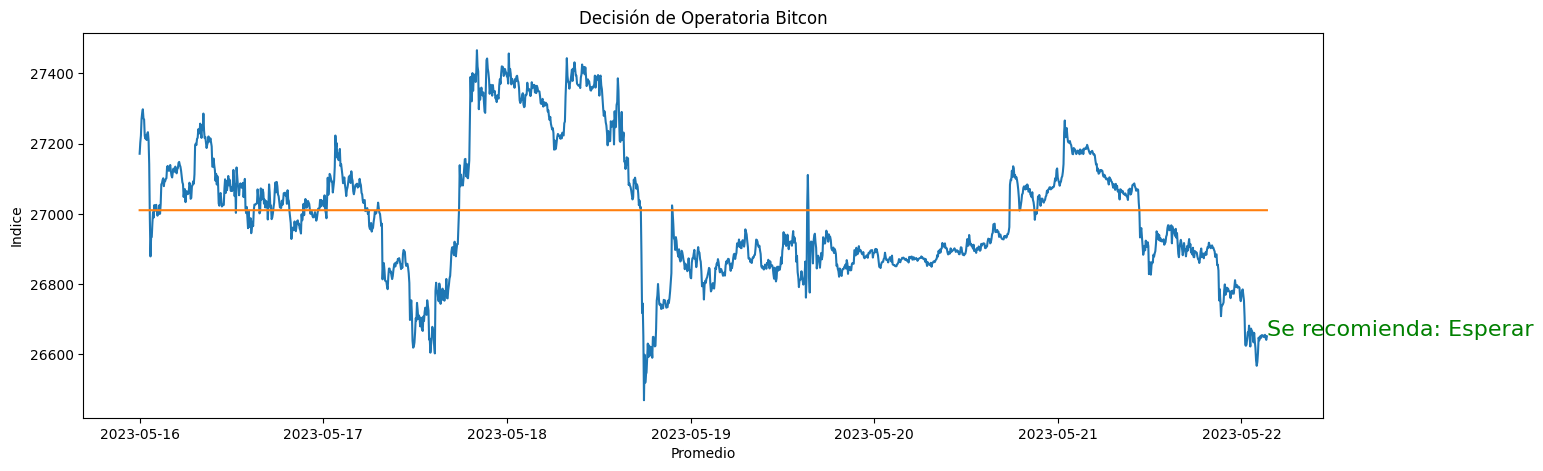

In [ ]:
visualizaciones()

##6. Automatización


Se sugiere Esperar


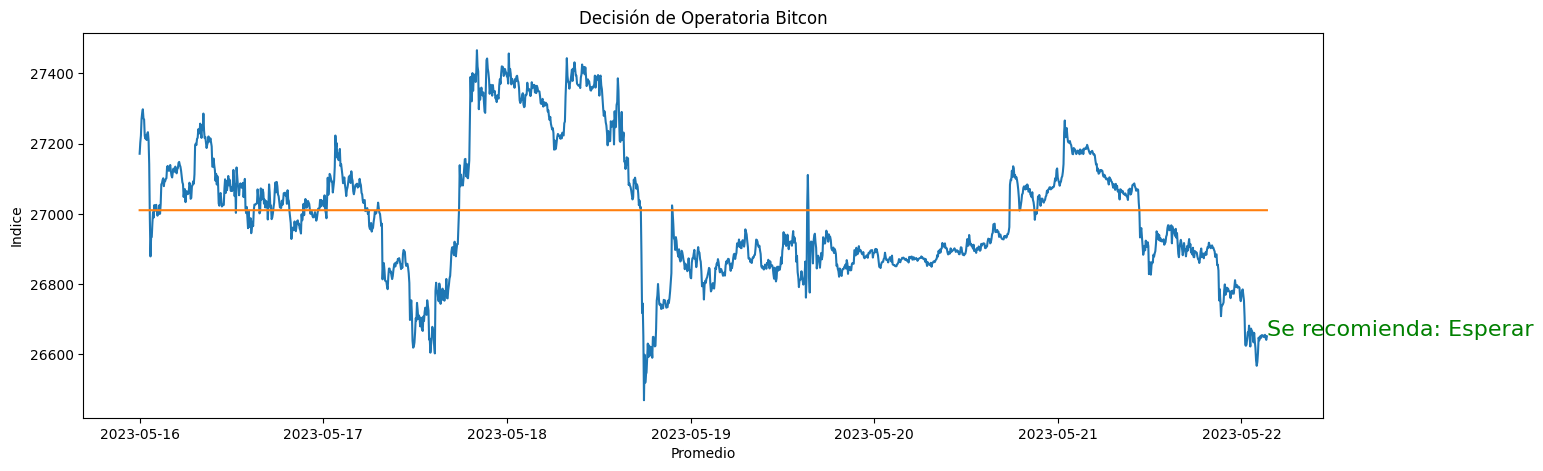

KeyboardInterrupt: ignored

In [ ]:
#Construiremos un loop infinito
from IPython.display import clear_output
import time

while(True):
  clear_output()
  limpieza_de_datos()
  importar_base_bitcoin
  extraer_tendencias()
  tomar_decisiones()
  visualizaciones()
  time.sleep(300)